<a href="https://colab.research.google.com/github/jamestheengineer/data-science-from-scratch-Python/blob/master/Chapter_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Clustering chapter. Example of unsupervised learning.

# Only do this once per VM, otherwise you'll get multiple clones and nested directories
!git clone https://github.com/jamestheengineer/data-science-from-scratch-Python.git
%cd data-science-from-scratch-Python/
!pip install import-ipynb
!pip install pillow
import import_ipynb

Cloning into 'data-science-from-scratch-Python'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 501 (delta 72), reused 3 (delta 1), pack-reused 387
Receiving objects: 100% (501/501), 1.36 MiB | 13.97 MiB/s, done.
Resolving deltas: 100% (312/312), done.
/content/data-science-from-scratch-Python
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=5261b05a9376a2c2ccea958d1c70b985725022ecb621ef054300ad74c68f7833
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [3]:
from Chapter_04 import Vector

def num_differences(v1: Vector, v2: Vector) -> int:
  assert len(v1) == len(v2)
  return len([x1 for x1, x2 in zip(v1,v2) if x1 != x2])

assert num_differences([1,2,3],[2,1,3]) == 2
assert num_differences([1,2],[1,2]) == 0

importing Jupyter notebook from Chapter_04.ipynb


In [5]:
from typing import List
from Chapter_04 import vector_mean

def cluster_means(k: int,
                  inputs: List[Vector],
                  assignments: List[int]) -> List[Vector]:
  # cluster[i] contains the inputs whose assignment is i
  clusters = [[] for i in range(k)]
  for input, assignment in zip(inputs, assignments):
    clusters[assignment].append(input)

  # if a cluster is empty, just use a random point
  return [vector_mean(cluster) if cluster else random.choice(inputs)
          for cluster in clusters]

In [ ]:
import itertools
import random
import tqdm
from Chapter_04 import squared_distance

class KMeans:
  def __init__(self, k: int) -> None:
    self.k = k
    self.means = None

  def classify(self, input: Vector) -> int:
    """return the index of the cluster closes to the input"""
    return min(range(self.k),
               key=lambda i: squared_distance(input, self.means[i]))
    
  def train(self, inputs: List[Vector]) -> None:
    # Start with random assignments
    assignments = [random.randrange(self.k) for _ in inputs]

    with tqdm.tqdm(itertools.count()) as t:
      for _ in t:
        # Compute means and find new assignments
        self.means = cluster_means(self.k, inputs, assignments)
        new_assignments = [self.classify(input) for input in inputs]

        # Check how many assignments changed and if we're done
        num_changed = num_differences(assignments, new_assignments)
        if num_changed == 0:
          return
        
        # Otherwise keep the new assignments, and compute new means
        assignments = new_assignments
        self.means = cluster_means(self.k, inputs, assignments)
        t.set_description(f"changed: {num_changed} / {len(inputs)}")

In [ ]:
# Meetup location example
inputs: List[List[float]] = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

random.seed(12)
clusterer = KMeans(k=3)
clusterer.train(inputs)
means = sorted(clusterer.means)

assert len(means) == 3

# Check that the means are close to what we expect
assert squared_distance(means[0], [-44, 5]) < 1
assert squared_distance(means[1], [-16, -10]) < 1
assert squared_distance(means[2], [18, 20]) < 1 
print(means)

changed: 5 / 20: : 0it [00:00, ?it/s]

[[-43.800000000000004, 5.4], [-15.888888888888888, -10.333333333333332], [18.333333333333332, 19.833333333333332]]


In [ ]:
# Only cash for two meetups, so...
random.seed(0)
clusterer = KMeans(k=2)
clusterer.train(inputs)
means = sorted(clusterer.means)

assert len(means) == 2
assert squared_distance(means[0], [-26, -5]) < 1
assert squared_distance(means[1], [18, 20]) < 1

changed: 4 / 20: : 0it [00:00, ?it/s]


0it [00:00, ?it/s]
changed: 8 / 20: : 0it [00:00, ?it/s]
changed: 2 / 20: : 0it [00:00, ?it/s]
changed: 2 / 20: : 0it [00:00, ?it/s]
changed: 2 / 20: : 0it [00:00, ?it/s]
changed: 1 / 20: : 0it [00:00, ?it/s]
changed: 1 / 20: : 0it [00:00, ?it/s]
changed: 4 / 20: : 0it [00:00, ?it/s]
changed: 2 / 20: : 0it [00:00, ?it/s]
changed: 4 / 20: : 0it [00:00, ?it/s]
changed: 1 / 20: : 0it [00:00, ?it/s]
changed: 1 / 20: : 0it [00:00, ?it/s]
changed: 1 / 20: : 0it [00:00, ?it/s]
changed: 1 / 20: : 0it [00:00, ?it/s]
changed: 1 / 20: : 0it [00:00, ?it/s]
changed: 3 / 20: : 0it [00:00, ?it/s]
changed: 1 / 20: : 0it [00:00, ?it/s]
changed: 3 / 20: : 0it [00:00, ?it/s]
changed: 3 / 20: : 0it [00:00, ?it/s]
changed: 1 / 20: : 0it [00:00, ?it/s]


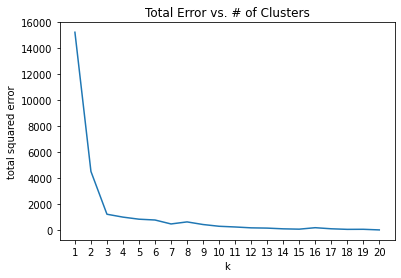

In [ ]:
# Choosing k by looking at the "bend"
from matplotlib import pyplot as plt 

def squared_clustering_errors(inputs: List[Vector], k: int) -> float:
  """finds the total squared error from k-means clustering the inputs"""
  clusterer = KMeans(k)
  clusterer.train(inputs)
  means = clusterer.means
  assignments = [clusterer.classify(input) for input in inputs]

  return sum(squared_distance(input, means[cluster])
              for input, cluster in zip(inputs, assignments))

# now plot from 1 up to len(inputs) clusters

ks = range(1, len(inputs) + 1)
errors = [squared_clustering_errors(inputs, k) for k in ks]

plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.title("Total Error vs. # of Clusters")
plt.show()

In [ ]:
image_path = r"test.jpg"
import matplotlib.image as mpimg
img = mpimg.imread(image_path) / 256

top_row = img[0]
top_left_pixel = top_row[0]
red, green, blue = top_left_pixel

pixels = [pixel.tolist() for row in img for pixel in row]

clusterer = KMeans(5)
clusterer.train(pixels)

changed: 7 / 262144: : 215it [20:17,  5.66s/it]


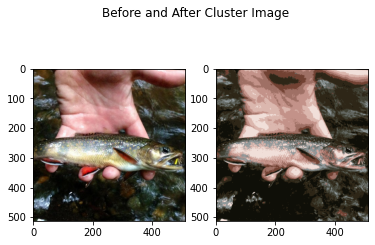

In [ ]:
def recolor(pixel: Vector) -> Vector:
  cluster = clusterer.classify(pixel)
  return clusterer.means[cluster]

new_img = [[recolor(pixel) for pixel in row]
           for row in img]
           
#plt.imshow(new_img)
#plt.axis('off')
#plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Before and After Cluster Image')
ax1.imshow(img)
ax2.imshow(new_img)

In [6]:
from typing import NamedTuple, Union

class Leaf(NamedTuple):
  value: Vector

leaf1 = Leaf([10,20])
leaf2 = Leaf([30, -15])

class Merged(NamedTuple):
  children: tuple
  order: int

merged = Merged((leaf1, leaf2), order = 1)

Cluster = Union[Leaf, Merged]

def get_values(cluster: Cluster) -> List[Vector]:
  if isinstance(cluster, Leaf):
    return [cluster.value]
  else:
    return [value
            for child in cluster.children
            for value in get_values(child)]

assert get_values(merged) == [[10,20],[30,-15]]

